In [1]:
import sys
import os
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))
from datasets.Waymo import WaymoDataset, waymo_collate_fn, create_idx
from model.layers.Spline import NaturalCubicSpline

In [2]:
tfrecord_path = '../../data1/waymo_dataset/uncompressed/tf_example/validation'
idx_path = '../../idx/validation'
dataset = WaymoDataset(tfrecord_path, idx_path)
dataloader = DataLoader(dataset, batch_size=1, collate_fn=lambda x: waymo_collate_fn(x))
road_map, agent_trajectories, unobserved_positions, future_times, target_velocity, target_occupancy_grid = next(iter(dataloader))

[[5126.775  4924.4204]
 [5126.8784 4924.4766]
 [5126.993  4924.5366]
 [5127.0977 4924.5957]
 [5127.2227 4924.6616]
 [5127.3545 4924.726 ]
 [5127.484  4924.797 ]
 [5127.637  4924.879 ]
 [5127.7935 4924.9634]
 [5127.9434 4925.0503]
 [5128.1025 4925.1255]]
[[-0.48760887 -7.88249403]
 [-0.54501675 -7.77966939]
 [-0.60646726 -7.66566266]
 [-0.6668165  -7.56189719]
 [-0.73425073 -7.43770861]
 [-0.80030342 -7.30666678]
 [-0.87267358 -7.17814341]
 [-0.95656453 -7.0258327 ]
 [-1.04293237 -6.87062224]
 [-1.13166418 -6.72178866]
 [-1.20879101 -6.56353583]]


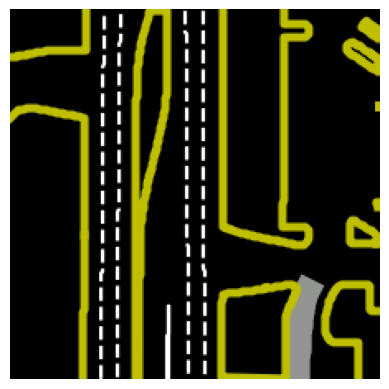

In [3]:
image_buffer = road_map[0].numpy() / 255.0
plt.imshow(image_buffer)
plt.axis('off')
plt.show()

tensor([[-0.4876, -7.8825],
        [-0.5450, -7.7797],
        [-0.6065, -7.6657],
        [-0.6668, -7.5619],
        [-0.7343, -7.4377],
        [-0.8003, -7.3067],
        [-0.8727, -7.1781],
        [-0.9566, -7.0258],
        [-1.0429, -6.8706],
        [-1.1317, -6.7218],
        [-1.2088, -6.5635]])


/tmp/ipykernel_33693/1550729022.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


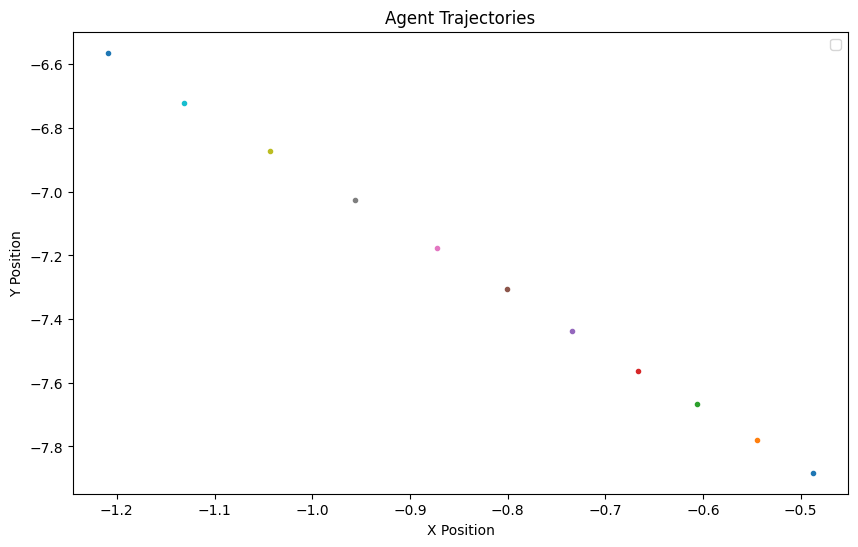

In [4]:
trajectories = agent_trajectories[0,0,:,:2]
#num_agents, seq_len, num_features = trajectories.shape
seq_len, num_features = trajectories.shape
print(trajectories)
t = torch.linspace(0., 1., seq_len).to(agent_trajectories)
spline = NaturalCubicSpline(t, trajectories)

plt.figure(figsize=(10, 6))

SAMPLING_FREQUENCY = 10
for i in range(SAMPLING_FREQUENCY+1):
    t = i / SAMPLING_FREQUENCY
    positions = spline.evaluate(t)
    plt.plot(positions[0].cpu().numpy(), positions[1].cpu().numpy(), 'o-', markersize=3)

plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Agent Trajectories')
plt.legend()
plt.show()